In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

import random

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
env = gym.make("BipedalWalker-v3", render_mode="human")
observation_space, info = env.reset()
action_space = env.action_space
action_space_dims = env.action_space.shape

print("ACTION SPACE:", env.action_space)
print("ACTION SPACE HIGH & LOW:", env.action_space.high, env.action_space.low)
print("OBSERVATION:", observation_space)

print("INFO:", info)

ACTION SPACE: Box(-1.0, 1.0, (4,), float32)
ACTION SPACE HIGH & LOW: [1. 1. 1. 1.] [-1. -1. -1. -1.]
OBSERVATION: [ 2.7474242e-03 -1.3681140e-05  1.0642530e-03 -1.5999906e-02
  9.1962650e-02 -1.4044552e-03  8.6026716e-01  2.4407522e-03
  1.0000000e+00  3.2367777e-02 -1.4043510e-03  8.5381782e-01
  9.9323876e-04  1.0000000e+00  4.4081402e-01  4.4582012e-01
  4.6142277e-01  4.8955020e-01  5.3410280e-01  6.0246104e-01
  7.0914888e-01  8.8593185e-01  1.0000000e+00  1.0000000e+00]
INFO: {}


# The goal is to train the [Bipedal Walker](https://gymnasium.farama.org/environments/box2d/bipedal_walker/) from Gym's box2d environvement.

# The Bipedal Walker problem involves a 24-dimensional continuous state space and a 4-dimensional continuous action space. 
# However, the traditional Deep-Q Network (DQN) approach is not suitable for such problems with continuous action spaces. This is because DQN selects the action with the maximum value, but in the continuous case, the number of possible actions is infinite, making it impossible to fit the problem with DQN.

# When dealing with problems that have continuous action spaces, the preferred approach is to use Actor-Critic methods. 
# This architecture consists of two components: the Actor, responsible for selecting actions, and the Critic, whose role is to evaluate and provide feedback, or "criticism," on the chosen actions. The Actor-Critic methods are particularly suitable for problems with continuous action spaces as they can approximate a policy function that maps state to action, enabling continuous and efficient learning.

# In the context of reinforcement learning algorithms, specifically for this project, I have opted to use the TD3 (Twin Delayed DDPG) algorithm, which is an advanced version of the Actor-Critic architecture. One key difference between the two architectures is that TD3 incorporates two Critic networks to evaluate the chosen action, enabling more robust evaluation and better learning. Additionally, TD3 includes various other improvements that enhance its performance compared to traditional Actor-Critic methods.

# The TD3 implementation is based on this [paper](https://arxiv.org/pdf/1802.09477.pdf) and the hyperparameters are also selected from it.

# Actor Implementation

In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(state_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, action_dim)
        )
        self.max_action = max_action

    def forward(self, x):
        x = self.max_action * torch.tanh(self.model(x))
        return x

# Critic Implementation

In [4]:
class Critic(nn.Module):    
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 400)
        self.l5 = nn.Linear(400, 300)
        self.l6 = nn.Linear(300, 1)


    def forward(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2


    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1

#  Implementation of the ReplayBuffer class. Replay Buffer is often used in RL problems, it stores accumulated experience in the following form: (state, action, next_state, reward, done) and serves two purposes:
* ## To prevent the model from learning from highly correlated consecutive experiences, a random selection is made from the accumulated experiences. This way, the model doesn't learn "wrong" things due to any patterns or biases in the order in which the experiences occur
* ## To speed up the learning process, the model is trained in batches, and the Replay Buffer provides a convenient mechanism for sampling these batches from the stored experiences.

## When new data is added to the buffer, it is passed as an argument to the add function. The buffer array has a maximum size limit, and if this limit is exceeded, the pointer is reset to the beginning of the array, and the oldest data is overwritten with the newest data.

In [5]:
class ReplayBuffer(object):
    def __init__(self, max_size=1000000):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):

        ind = np.random.randint(0, len(self.storage), size=batch_size)
        states, actions, next_states, rewards, dones = [], [], [], [], []

        for i in ind:
            s, a, ns, r, d = self.storage[i]
            states.append(np.array(s, copy=False))
            actions.append(np.array(a, copy=False))
            next_states.append(np.array(ns, copy=False))
            rewards.append(np.array(r, copy=False))
            dones.append(np.array(d, copy=False))

        return np.array(states), np.array(actions), np.array(next_states), np.array(rewards).reshape(-1, 1), np.array(
            dones).reshape(-1, 1)


# TD3 Agent Implementation

* ## Standard DQN architectures often use the epsilon-greedy method to select actions. However, in continuous action spaces, choosing a random function for action selection is not very effective. Therefore, to introduce some randomness in the actions, noise sampled from the normal distribution is added instead.
**  ## To prevent the added noise from being too extreme, the clamp() function is applied to keep the noise within certain limits.
* ## To improve the stability and convergence of the learning algorithm, target networks are periodically updated. This technique involves creating a separate target network that has the same architecture as the primary network but with frozen weights. The target network is updated periodically by slowly blending its weights with those of the primary network.

In [6]:
class TD3(object):    
    def __init__(self, state_dim, action_dim, max_action, env, 
                 discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
        
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

        self.max_action = max_action
        self.env = env
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq

        
    def select_action(self, state, noise=0.1):
#         print("STAATEE:", state)
#         print("TYPE:", type(state))
#         print()
        state = torch.Tensor(state.reshape(1, -1)).to(device)
        
        action = self.actor(state).cpu().data.numpy().flatten()
        if noise != 0: 
            action = (action + np.random.normal(0, noise, size=self.env.action_space.shape[0]))
            
        return action.clip(self.env.action_space.low, self.env.action_space.high)

    
    def train(self, replay_buffer, iterations, batch_size=256):
        for it in range(iterations):

            # Sample replay buffer 
#             obs, new_obs, action, reward, done
            s, a, ns, r, d = replay_buffer.sample(batch_size)
#             s, ns, a, r, d = replay_buffer.sample(batch_size)
#             print("TYPE S:", type(s))
#             print("S:", s)
#             print("A:", a)
#             print("NS:", ns)
#             print("R:", r)
#             print("D:", d)
            state = torch.FloatTensor(s).to(device)
            action = torch.FloatTensor(a).to(device)
            next_state = torch.FloatTensor(ns).to(device)
            done = torch.FloatTensor(1 - d).to(device)
            reward = torch.FloatTensor(r).to(device)

            # ექშენისთვის ხმაურის დამატება
            noise = torch.FloatTensor(a).data.normal_(0, self.policy_noise).to(device)
            noise = noise.clamp(-self.noise_clip, self.noise_clip)
            next_action = (self.actor_target(next_state) + noise).clamp(-self.max_action, self.max_action)

            # target_Q ვალიუები
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + (done * self.discount * target_Q).detach()

            # ახლანდელი Q ვალიუები
            current_Q1, current_Q2 = self.critic(state, action)

            # კრიტიკის loss გამოთვლა
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q) 

            # კრიტიკის ოპტიმიზაცია
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # target ნეთვორქების განახლება
            if it % self.policy_freq == 0:

                actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


    def save(self, filename, directory):        
        torch.save(self.actor.state_dict(), f"{directory}/{filename}_actor.pth")
        torch.save(self.critic.state_dict(), f"{directory}/{filename}_critic.pth")


    def load(self, filename="best_avg", directory="./saves"):
        self.actor.load_state_dict(torch.load(f"{directory}/{filename}_actor.pth"))
        self.critic.load_state_dict(torch.load(f"{directory}/{filename}_critic.pth"))

## This code is used to test the learned policy after the training is complete. Once the model has been trained, it can be used to interact with the environment and make decisions based on the learned policy. 

In [7]:
def evaluate_policy(policy, env, eval_episodes=50):
    avg_reward = 0
    for i in range(eval_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action = policy.select_action(np.array(obs), noise=0)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            avg_reward += reward

    avg_reward /= eval_episodes

    print(f"Evaluation over {eval_episodes:d} episodes: {avg_reward:f}")
    return avg_reward

In [8]:
ENV = "BipedalWalker-v3"
SEED = 0
OBSERVATION = 10000
MAX_TIMESTEPS = 5000000
START_TIMESTEPS = 10000
BATCH_SIZE = 256
GAMMA = 0.99
TAU = 0.005
NOISE = 0.2
NOISE_CLIP = 0.5
EXPLORE_NOISE = 0.1
POLICY_FREQUENCY = 2
EVAL_FREQUENCY = 5000
REWARD_THRESH = 8000

# Creating environment and initalizing objects. We pass the torch and numpy seeds so that we the experiments can be repeated.

In [9]:
# env = gym.make(ENV, hardcore=True)
env = gym.make(ENV)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(SEED)
np.random.seed(SEED)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

policy = TD3(state_dim, action_dim, max_action, env, GAMMA, TAU, NOISE, NOISE_CLIP, POLICY_FREQUENCY)

replay_buffer = ReplayBuffer()

# The ReplayBuffer is initially filled with random actions, this reduces the dependency on initial parameters.

In [10]:
time_steps = 0
obs, _ = env.reset()
done = False

for time_steps in range(START_TIMESTEPS):
    action = env.action_space.sample()
    new_obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    replay_buffer.add((obs, action, new_obs, reward, done))

    obs = new_obs
    
    if done:
        obs, _ = env.reset()
        done = False

print("Buffer Populated")

Buffer Populated


## If our model is already trained and we want to run the notebook again, we should set train_bool = False.

In [11]:
train_bool = True

In [12]:
if train_bool:
    
    total_timesteps = 0
    timesteps_since_eval = 0
    episode_num = 0
    episode_reward = 0
    episode_timesteps = 0
    done = False 
    obs, _ = env.reset()
    evaluations = []
    rewards = []
    best_avg = -500

    for t in range(MAX_TIMESTEPS):
        action = policy.select_action(np.array(obs))
        new_obs, reward, terminated, truncated, _ = env.step(action) 
        done = terminated or truncated
    #     print(done)
    #     print(new_obs)
    #     print("TIMESTEPS:", episode_timesteps)
        done = done or (episode_timesteps >= env._max_episode_steps)

        replay_buffer.add((obs, action, new_obs, reward, done))

        obs = new_obs
        episode_reward += reward
        episode_timesteps += 1    

        if done:
            rewards.append(episode_reward)
            avg_reward = np.mean(rewards[-100:])

            if best_avg < avg_reward:
                best_avg = avg_reward
                print(" saving best model...\n")
                policy.save("best_model", "models")

            print(f"\rTotal T: {t:d} Episode Num: {episode_num:d} Reward: {episode_reward:f} Avg Reward: {avg_reward:f}", end="")

            policy.train(replay_buffer, episode_timesteps, BATCH_SIZE)

            # Reset environment
            obs, _ = env.reset()
            done = False
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1
    else:
        print("train_bool is set to False.")


 saving best model...

Total T: 109 Episode Num: 0 Reward: -118.093099 Avg Reward: -118.093099 saving best model...

Total T: 262 Episode Num: 1 Reward: -114.217180 Avg Reward: -116.155140 saving best model...

Total T: 386 Episode Num: 2 Reward: -110.621706 Avg Reward: -114.310662 saving best model...

Total T: 140193 Episode Num: 318 Reward: -104.459033 Avg Reward: -101.927316 saving best model...

Total T: 141793 Episode Num: 319 Reward: -69.491669 Avg Reward: -101.462289 saving best model...

Total T: 144993 Episode Num: 321 Reward: -122.137777 Avg Reward: -100.961437 saving best model...

Total T: 145064 Episode Num: 322 Reward: -107.115136 Avg Reward: -100.874600 saving best model...

Total T: 146982 Episode Num: 325 Reward: -107.993213 Avg Reward: -100.531892 saving best model...

Total T: 148582 Episode Num: 326 Reward: -107.255291 Avg Reward: -100.322951 saving best model...

Total T: 150182 Episode Num: 327 Reward: -48.867234 Avg Reward: -99.787230 saving best model...

Total

KeyboardInterrupt: 

# I recreate the environment with the render_mode='human' argument so we can see how our model works.

In [13]:
policy.load("best_model", "models")
env = gym.make(ENV, render_mode='human')

In [14]:
for i in range(100):
    evaluate_policy(policy, env)

KeyboardInterrupt: 

# Visualization of rewards over time.

Text(0.5, 1.0, 'Rewards Over Time')

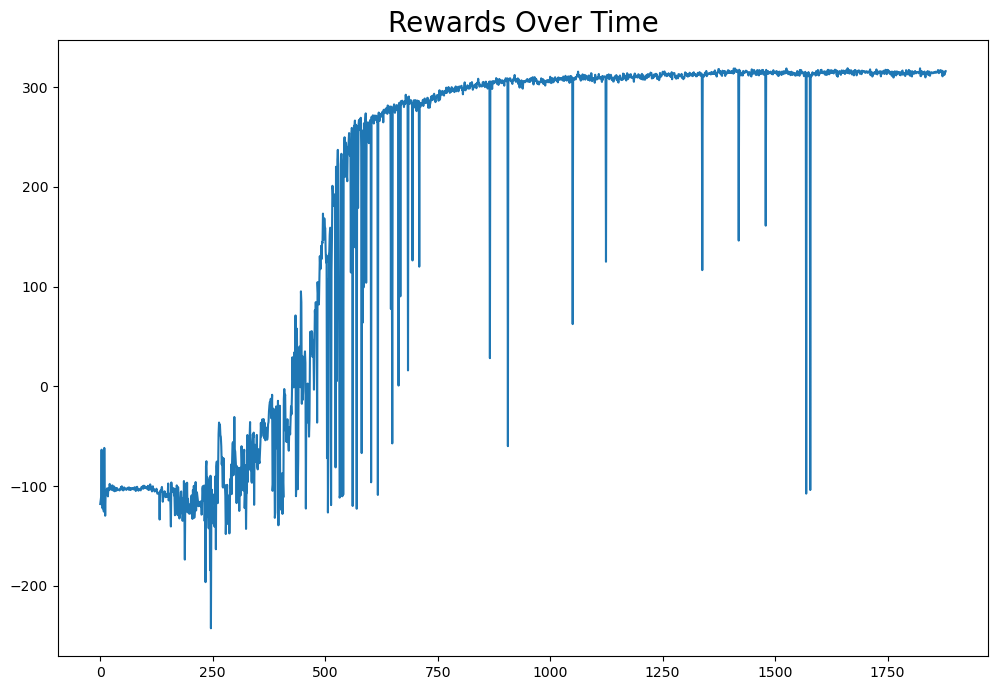

In [15]:
plt.figure(figsize=(12, 8))
plot = sns.lineplot(rewards)
font_dict = {'fontsize': 20}
plot.set_title('Rewards Over Time', **font_dict)
# help(plot.set_title)

## As can be observed, the rewards steadily increased over time and after approximately 1-2 hours of training (on RTX 3060TI), the desired reward of 300 was achieved.

## During the course of the project, I experimented with several other networks, including the standard Actor-Critic architecture. However, I noticed that it did not scale well and there was significant variation in model performance across different runs. As a result, I ultimately decided to use TD3 for the following reasons:
1) ## TD3 is a state-of-the-art algorithm and has been shown to achieve good results in various RL tasks.
2) ## I was interested in understanding how TD3 worked and wanted to implement it from scratch to deepen my understanding of the algorithm.